In [1]:
import requests
import sys
sys.path.append('src')
from paco.parser.parse_tree import ParseTree
from paco.execution_tree.execution_tree import ExecutionTree
from paco.explainer.bdd.bdds import bdds_from_json

headers = {
	"Content-Type": "application/json",
}
url = "http://127.0.0.1:8000/"

## Read a bundle from the CPI dataset

In [2]:
import random
from experiments.etl.read import read_cpi_bundles
from experiments.etl.cpi_translations import cpi_to_standard_format

bundles = read_cpi_bundles(x=1,y=1)
print("Size: ", len(bundles))

bpmn = cpi_to_standard_format(random.choice(bundles))
bpmn

Size:  5400


{'expression': '((T1 || T2), (T3 /[C1] T4))',
 'impacts_names': ['impact_1', 'impact_2', 'impact_3', 'impact_4', 'impact_5'],
 'impacts': {'T1': [0.0008447131433286691,
   0.0,
   0.006813932997858115,
   0.0,
   0.0],
  'T2': [0.0, 0.009267342847610039, 5.707414471600392e-06, 0.0, 0.0],
  'T3': [5.531165857895353e-06, 0.0, 0.0, 0.0, 0.0],
  'T4': [0.0, 0.0, 0.0006417325244227825, 0.0, 0.007887835644968108]},
 'durations': {'T1': [0, 7], 'T2': [0, 1], 'T3': [0, 7], 'T4': [0, 4]},
 'probabilities': {},
 'delays': {'C1': 1},
 'loop_round': {},
 'loop_probability': {},
 'h': 0}

### Check BPMN

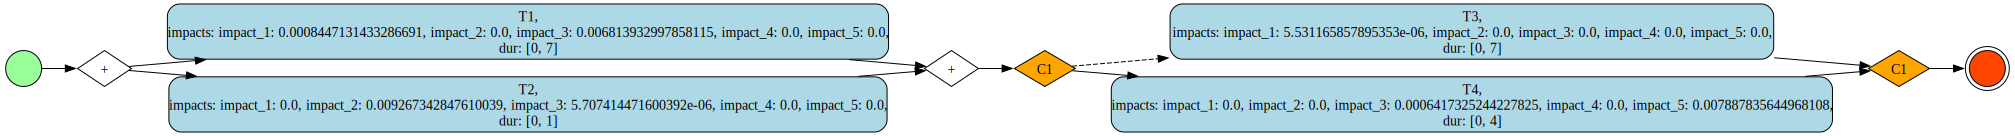

In [3]:
import graphviz
from IPython.display import display, SVG

try:
	resp = requests.get(f'{url}create_bpmn', json={'bpmn': bpmn},  headers=headers)
	resp.raise_for_status()
	display(SVG(graphviz.Source(resp.json()['bpmn_dot']).pipe(format="svg")))

except requests.exceptions.HTTPError as e:
	print(f"HTTP Error ({resp.status_code}):", resp.json())

### Create the Execution tree

Sampled Expected Impact: [0.0008447131433286691, 0.009267342847610039, 0.007461372936752498, 0.0, 0.007887835644968108]


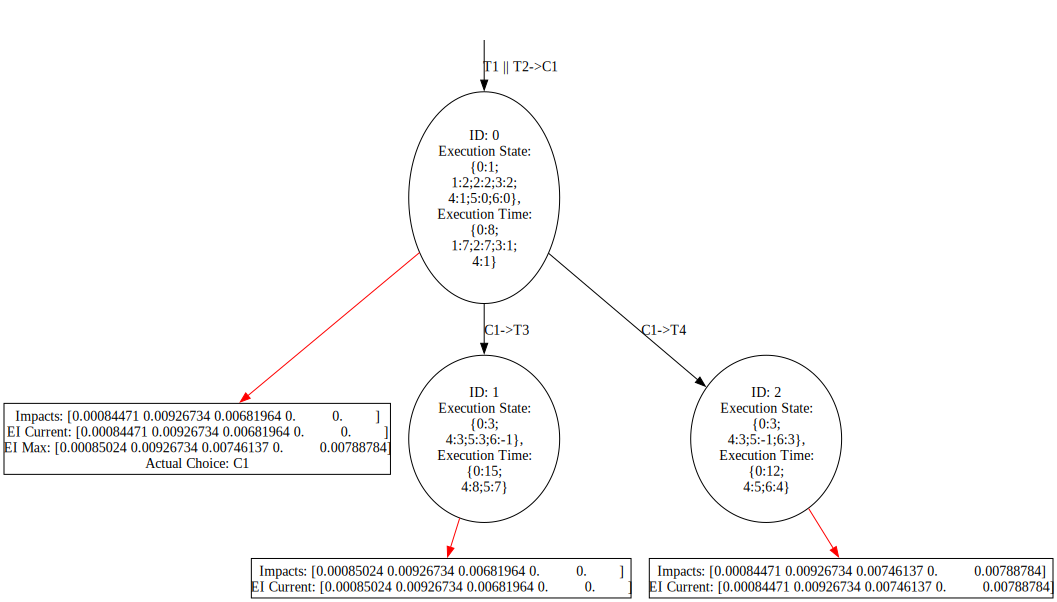

In [4]:
execution_tree = None
try:
	resp = requests.get(f'{url}create_execution_tree', json={"bpmn": bpmn},  headers=headers)
	resp.raise_for_status()

	response = resp.json()
	parse_tree, _,_ = ParseTree.from_json(response["parse_tree"], len(bpmn["impacts_names"]), 0)

	bound = parse_tree.sample_expected_impact()
	print(f"Sampled Expected Impact: {bound}")

	execution_tree = ExecutionTree.from_json(parse_tree, response["execution_tree"], bpmn["impacts_names"])
	dot = execution_tree.to_dot(state=True, executed_time=True, diff=True)
	display(SVG(graphviz.Source(dot).pipe(format="svg")))

except requests.exceptions.HTTPError as e:
	print(f"HTTP Error ({resp.status_code}):", resp.json())

This is the strategy, with an expected impact of: impact_1: 0.0 impact_2: 0.01 impact_3: 0.01 impact_4: 0.0 impact_5: 0.01


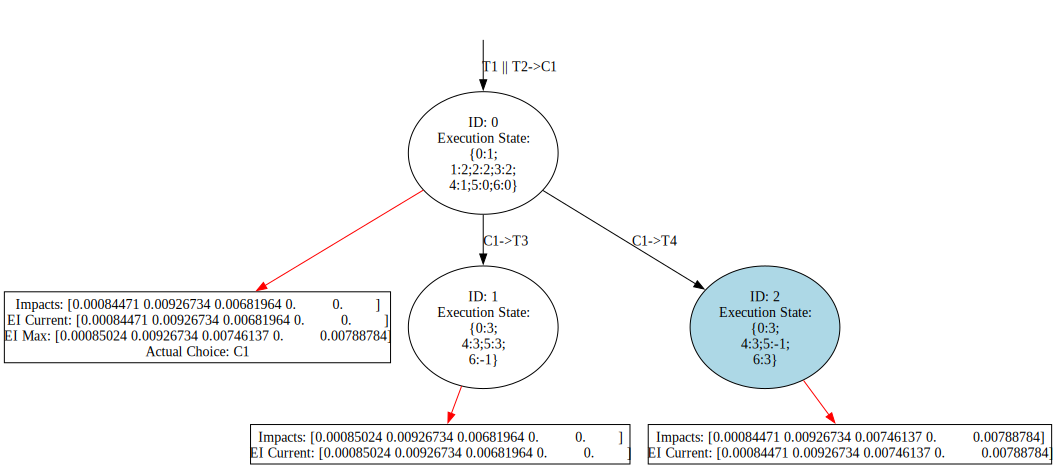

1 is dashed line of BPMN or Parse Tree
C1: FORCED_DECISION


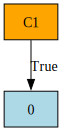

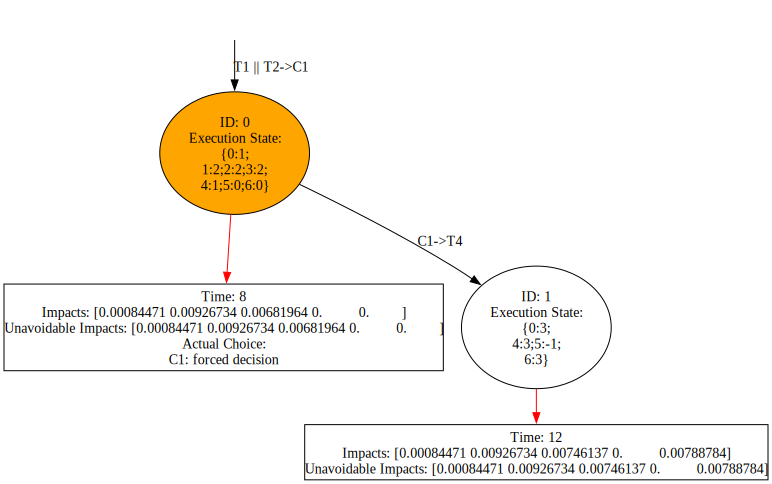

In [5]:
try:
	resp = requests.get(f'{url}create_strategy', json={"bpmn": bpmn, "bound": bound, "parse_tree": parse_tree.to_dict(), "execution_tree": execution_tree.to_dict()}, headers=headers)
	resp.raise_for_status()

	response = resp.json()
	print(response["result"])

	frontier_solution_id = set()
	if "frontier_solution" in response: # Solution Found
		frontier_solution_id = set(map(int, response["frontier_solution"].strip("[]").split(",")))

	# With frontier node in blue
	dot = execution_tree.to_dot(state=True, executed_time=False, diff=True, frontier=frontier_solution_id)
	display(SVG(graphviz.Source(dot).pipe(format="svg")))

	if "strategy_tree" in response:
		explained_choices = bdds_from_json(parse_tree, response["bdds"])
		print("1 is dashed line of BPMN or Parse Tree")
		for choice, bdd in explained_choices.items():
			print(f"{choice.name}: {bdd.typeStrategy}")
			svg_data = graphviz.Source(bdd.bdd_to_dot()).pipe(format="svg")
			display(SVG(svg_data))

		strategy_tree = ExecutionTree.from_json(parse_tree, response["strategy_tree"], bpmn["impacts_names"], explained_choices)

		#TREE_STATE
		dot = strategy_tree.to_dot(state=True, executed_time=False, diff=True)
		display(SVG(graphviz.Source(dot).pipe(format="svg")))

except requests.exceptions.HTTPError as e:
	print(f"HTTP Error ({resp.status_code}):", resp.json())